In [ ]:
# Run this first. It installs packages used later.
!pip install pdfplumber tqdm textblob nltk gensim scikit-learn wordcloud matplotlib seaborn pyLDAvis pandas spacy
# For mallet wrapper (gensim includes wrapper; but we may need javapaths)
!pip install mallet-wrapper

# TextBlob corpora and NLTK downloads will be performed in later cells.


ERROR: Could not find a version that satisfies the requirement mallet-wrapper (from versions: none)
ERROR: No matching distribution found for mallet-wrapper


In [ ]:
import pdfplumber
from tqdm import tqdm

pdf_path = '/trent_fy24-25_annual_report.pdf'  # since file is in Colab directly
pages = []

with pdfplumber.open(pdf_path) as pdf:
    for p in tqdm(pdf.pages):
        text = p.extract_text()
        if text:
            pages.append(text)

len(pages), pages[:2]


100%|██████████| 236/236 [01:03<00:00,  3.71it/s]


(236,
 ['A G I L E . S C A L E . D E S I R A B L E .\nINTEGRATED ANNUAL REPORT 2025',
  'Our Founder In Remembrance\nJamsetji Nusserwanji Tata Padma Vibhushan\nMr. Ratan N Tata\n3rd March 1839 – 19th May 1904\n28th December 1937 – 9th October 2024\n"In a free enterprise, the community is It is with a profound sense of loss that we bid farewell to Mr. Ratan Naval Tata,\na truly uncommon leader whose immeasurable contributions have shaped not only the\nnot just another stakeholder in business,\nTata Group but also the very fabric of our nation.\nbut is in fact the very purpose of For the Tata Group, Mr. Tata was more than a chairperson. He inspired by example.\nWith an unwavering commitment to excellence, integrity and innovation, the\nits existence."\nTata Group under his stewardship expanded its global footprint while always remaining\ntrue to its moral compass.\nMr. Tata’s dedication to philanthropy and the development of society has touched the lives\nof millions. From education to h

In [ ]:
import pandas as pd

df = pd.DataFrame({
    'page_num': range(1, len(pages)+1),
    'text': pages
})

df.head()




,page_num,text
0,1,A G I L E . S C A L E . D E S I R A B L E .\nI...
1,2,Our Founder In Remembrance\nJamsetji Nusserwan...
2,3,Trent Limited\nAbout\nthe Report\nReporting Ap...
3,4,Trent Limited\nTable of\nContents\nAbout the R...
4,5,Trent Limited\nThis is Us\n6 Integrated Annual...


In [ ]:
import re
import nltk
from nltk.corpus import stopwords


nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')   # 🔹 Add this line to fix the LookupError

stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)                      # remove digits
    text = re.sub(r'[^\w\s]', '', text)                  # remove punctuation
    text = re.sub(r'\s+', ' ', text)                     # remove extra spaces
    words = nltk.word_tokenize(text)
    words = [w for w in words if w not in stop_words]
    return ' '.join(words)

df['clean_text'] = df['text'].apply(clean_text)
df.head()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


,page_num,text,clean_text
0,1,A G I L E . S C A L E . D E S I R A B L E .\nI...,g l e c l e e r b l e integrated annual report
1,2,Our Founder In Remembrance\nJamsetji Nusserwan...,founder remembrance jamsetji nusserwanji tata ...
2,3,Trent Limited\nAbout\nthe Report\nReporting Ap...,trent limited report reporting approach bdo in...
3,4,Trent Limited\nTable of\nContents\nAbout the R...,trent limited table contents report statutory ...
4,5,Trent Limited\nThis is Us\n6 Integrated Annual...,trent limited us integrated annual report


In [ ]:
from textblob import TextBlob
from nltk.tokenize import sent_tokenize
nltk.download('punkt_tab')

sentiments = []

for i, text in enumerate(df['text']):
    sentences = sent_tokenize(text)
    for sent in sentences:
        blob = TextBlob(sent)
        sentiments.append({
            'page_num': i+1,
            'sentence': sent,
            'polarity': blob.sentiment.polarity,
            'subjectivity': blob.sentiment.subjectivity
        })

sent_df = pd.DataFrame(sentiments)
sent_df.head()


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


,page_num,sentence,polarity,subjectivity
0,1,A G I L E .,0.000000,0.000000
1,1,S C A L E .,0.000000,0.000000
2,1,D E S I R A B L E .,0.000000,0.000000
3,1,INTEGRATED ANNUAL REPORT 2025,0.000000,0.000000
4,2,Our Founder In Remembrance\nJamsetji Nusserwan...,0.247222,0.683333


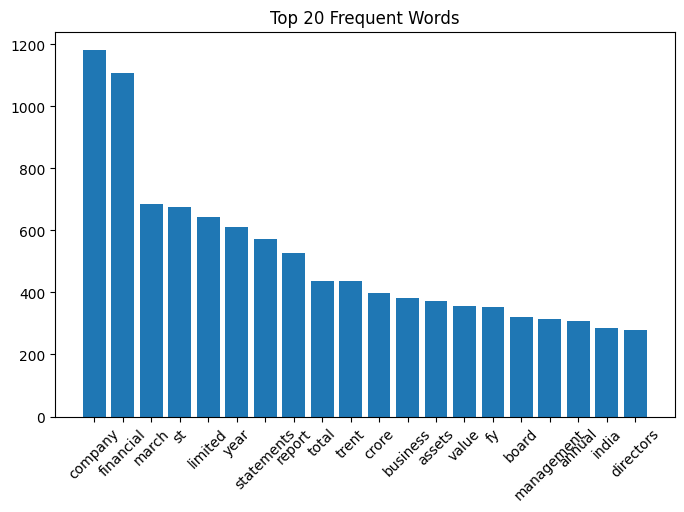

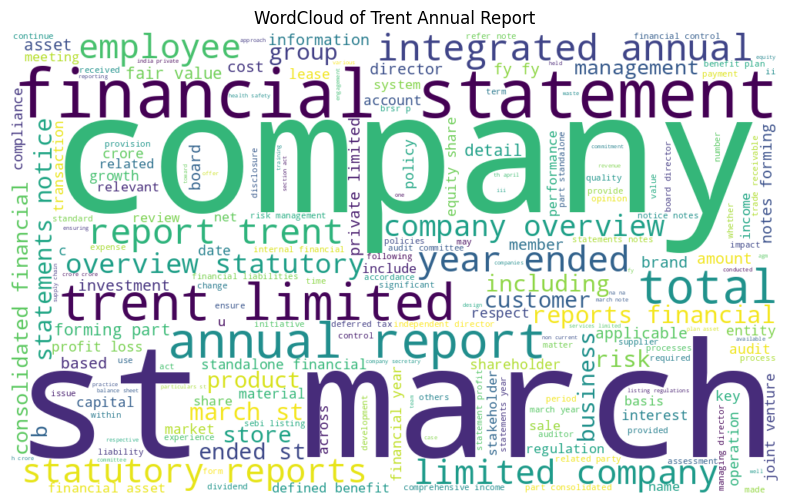

In [ ]:
from wordcloud import WordCloud
from collections import Counter
import matplotlib.pyplot as plt

all_words = ' '.join(df['clean_text'])
word_freq = Counter(all_words.split())
common_words = word_freq.most_common(20)

plt.figure(figsize=(8,5))
plt.bar([w[0] for w in common_words], [w[1] for w in common_words])
plt.xticks(rotation=45)
plt.title('Top 20 Frequent Words')
plt.show()

wordcloud = WordCloud(width=1000, height=600, background_color='white').generate(all_words)
plt.figure(figsize=(10,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud of Trent Annual Report')
plt.show()


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

tfidf_vectorizer = TfidfVectorizer(max_features=2000)
tfidf_matrix = tfidf_vectorizer.fit_transform(df['clean_text'])

vectorizer = CountVectorizer(max_features=2000)
dtm = vectorizer.fit_transform(df['clean_text'])

tfidf_matrix.shape, dtm.shape


((236, 2000), (236, 2000))

In [ ]:
import gensim
from gensim import corpora
from gensim.models import LdaModel
from pprint import pprint

# Tokenize each page
tokenized_data = [text.split() for text in df['clean_text']]

dictionary = corpora.Dictionary(tokenized_data)
corpus = [dictionary.doc2bow(text) for text in tokenized_data]

lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=10,
    random_state=42,
    passes=10
)

topics = lda_model.print_topics(num_words=5)
pprint(topics)


[(0,
  '0.028*"company" + 0.014*"board" + 0.012*"directors" + 0.011*"committee" + '
  '0.010*"report"'),
 (1,
  '0.015*"march" + 0.013*"limited" + 0.013*"st" + 0.012*"company" + '
  '0.010*"total"'),
 (2,
  '0.011*"us" + 0.011*"growth" + 0.007*"stores" + 0.007*"market" + '
  '0.006*"across"'),
 (3,
  '0.011*"integrated" + 0.011*"trent" + 0.011*"company" + 0.010*"stores" + '
  '0.010*"across"'),
 (4,
  '0.033*"financial" + 0.021*"march" + 0.020*"st" + 0.016*"statements" + '
  '0.014*"assets"'),
 (5,
  '0.011*"waste" + 0.009*"energy" + 0.008*"value" + 0.007*"total" + 0.006*"p"'),
 (6,
  '0.019*"limited" + 0.016*"year" + 0.016*"detimil" + 0.016*"benefit" + '
  '0.014*"plan"'),
 (7,
  '0.009*"value" + 0.008*"report" + 0.006*"trent" + 0.006*"employees" + '
  '0.006*"sustainability"'),
 (8,
  '0.021*"shares" + 0.016*"company" + 0.014*"evoting" + 0.011*"members" + '
  '0.010*"shareholders"'),
 (9,
  '0.020*"fy" + 0.018*"crore" + 0.015*"limited" + 0.015*"total" + '
  '0.014*"financial"')]


In [ ]:
import pyLDAvis.gensim
import pyLDAvis
pyLDAvis.enable_notebook()

pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.188050  0.070887       1        1  23.523939
0     -0.045163 -0.064081       2        1  20.392743
9     -0.042302  0.028662       3        1  10.419604
5      0.027334  0.086482       4        1   8.747879
3      0.223215 -0.011004       5        1   8.660156
8     -0.105916 -0.244376       6        1   7.136545
1     -0.065567  0.051745       7        1   6.852340
7      0.100325  0.034803       8        1   6.666893
6     -0.084096  0.085844       9        1   6.470525
2      0.180220 -0.038963      10        1   1.129376, topic_info=               Term        Freq       Total Category  logprob  loglift
60            march  665.000000  665.000000  Default  30.0000  30.0000
2166         shares  188.000000  188.000000  Default  29.0000  29.0000
416              fy  316.000000  316.000000  Default  28.0000  28.0000
242              st  655.000000  655.000000  Default  27.0000  27.0000
182         limited  587.000000  587.000000  Default  26.0000  26.0000
...             ...         ...         ...      ...      ...      ...
110        approach    2.790962   42.098205  Topic10  -5.8045   1.7699
1453    proposition    2.595453   28.370506  Topic10  -5.8771   2.0919
257           trent    3.598255  399.105827  Topic10  -5.5504  -0.2253
175   international    2.642532   34.510333  Topic10  -5.8592   1.9140
0            annual    2.740537  287.422033  Topic10  -5.8227  -0.1693

[755 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
5428      3  0.905976     abeyance
621       2  0.090608  accessories
621       4  0.090608  accessories
621       8  0.724866  accessories
2724      1  0.180207      account
...     ...       ...          ...
602       2  0.075434        zudio
602       3  0.113150        zudio
602       5  0.641186        zudio
602       8  0.132009        zudio
602      10  0.037717        zudio

[2172 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 1, 10, 6, 4, 9, 2, 8, 7, 3])

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
df.to_csv('trent_cleaned_text.csv', index=False)
sent_df.to_csv('trent_sentence_sentiments.csv', index=False)


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag